In [7]:
import pandas as pd
from gensim.models import KeyedVectors
from nltk.tokenize import WordPunctTokenizer
import numpy as np
import bokeh.models as bm, bokeh.plotting as pl
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
import string
from pymystem3 import Mystem
import pymorphy2

output_notebook()

tokenizer = WordPunctTokenizer()
m = Mystem()

data_path = "../data/yandex_output.csv"
vec_path = "../data/cc.ru.300.vec"

Loading BokehJS ...

### Обработка данных
Загрузим все данные из файла и выведем их, а также все названия колонок

In [8]:
df = pd.read_csv(data_path)
df.head()

,company_categories,company_features,company_links,company_name,company_url,phone_number,source
0,Спецтехника и спецавтомобили;Услуги грузчиков;...,коммунальная техника,https://vk.com/pr.bratsk,Компания Персональное решение,NaN,73953274827,Yandex API
1,Агентство недвижимости,NaN,NaN,АН Индустриальное,NaN,79028351016,Yandex API
2,Стоматологическая поликлиника;Стоматологическа...,детская;услуги,https://vk.com/club129411917;http://izhevsk.st...,Стоматология 32 Жемчужины,NaN,79120189455,Yandex API
3,Аптека,оплата картой,NaN,Аптека для бережливых,NaN,78124426652,Yandex API
4,"Регистрационная палата;Министерства, ведомства...",NaN,https://twitter.com/rosreestr_info;https://vk....,Межрайонный отдел № 2 г. Перми Управления Роср...,NaN,73422836588,Yandex API


In [9]:
df.columns

Index(['company_categories', 'company_features', 'company_links',
       'company_name', 'company_url', 'phone_number', 'source'],
      dtype='object')

### Обработка данных
Удаляем ненужные столцы

Оказвается, что колонки __source__ и __company_url__ можно удалить из нашей таблицы, так как они не содержат уникальных значений

In [10]:
print(df['source'].unique(), df['company_url'].unique())

['Yandex API'] [nan]


In [11]:
del df["source"]
del df["company_url"]

### Обработка данных
Обрабатываем адреса

Преобразуем в списки и удаляем ненужные query параметры в url

In [12]:
df['company_links'] = df['company_links'].apply(lambda x: str(x).split(';'))
df['company_links'] = df['company_links'].apply(lambda x:  ['/'.join(str(y).split('/')[:4]) for y in x])

In [13]:
df.head()

,company_categories,company_features,company_links,company_name,phone_number
0,Спецтехника и спецавтомобили;Услуги грузчиков;...,коммунальная техника,[https://vk.com/pr.bratsk],Компания Персональное решение,73953274827
1,Агентство недвижимости,NaN,[nan],АН Индустриальное,79028351016
2,Стоматологическая поликлиника;Стоматологическа...,детская;услуги,"[https://vk.com/club129411917, http://izhevsk....",Стоматология 32 Жемчужины,79120189455
3,Аптека,оплата картой,[nan],Аптека для бережливых,78124426652
4,"Регистрационная палата;Министерства, ведомства...",NaN,"[https://twitter.com/rosreestr_info, https://v...",Межрайонный отдел № 2 г. Перми Управления Роср...,73422836588


### Загрузка модели

Поиграемся пока просто с категорией компании

Загрузим обученную модель word2vec

Объявим набор простых функций 

In [14]:
MODEL = KeyedVectors.load_word2vec_format(vec_path)
UNRECOGNIZED_WORDS = []

In [15]:
def tokinize_phrase(phrase):
    """
      Токинизирует фразу
    """
    return tokenizer.tokenize(phrase)


def get_phrase_embedding(phrase):
    """
        Возвращает усредненное значение embeddings
    """
    phrase = phrase.lower()
    phrase_tokinized = tokinize_phrase(phrase)
    result = 0
    count = 0
    for word in phrase_tokinized:
        if word in MODEL.key_to_index.keys():
            result += MODEL.get_vector(word)
            count += 1
        else:
            UNRECOGNIZED_WORDS.append(word)

    result = result / count if (count != 0 and len(result) > 0) else np.zeros(300)
    if result.shape != (300, ):
        raise Exception("Wrong shape")
        
    if type(result) != type(np.zeros(1)):
        print(phrase)
        raise Exception("Wrong format")
    return result.tolist()


def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    
    """
        Красиво рисует вектора embeddings
    """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig


def pos(word, morth=pymorphy2.MorphAnalyzer()):
    """
        Возвращает тип слова, например, предлог или еще что-то
    """
    return morth.parse(word)[0].tag.POS


def delete_prep(phrase):
    """
        Удаляет предлоги, союзы и тд
    """
    functors_pos = {'INTJ', 'PRCL', 'CONJ', 'PREP'}
    return ' '.join([word for word in phrase.split() if pos(word) not in functors_pos])


def lemmatize(phrase):
    """
        Лемматизирует слово
    """
    lemmas = m.lemmatize(phrase)
    if lemmas[-1] == '\n':
        return ''.join(lemmas[:-1])
    else:
        return ''.join(lemmas)

### Предложение 1. 



Общий подход:
    - у нас имеются вектора описания по каждому описанию компании. Их надо кластеризовать. 

Первым делом попробуем все визуализировать

In [16]:
"""
    Создаем колонку embeddings, куда сохраняем все вектора описаний
"""

df['embedding'] = df.company_categories.apply(lambda x: get_phrase_embedding(x))

embeddings = np.matrix(df['embedding'].tolist())
phrases = df.company_categories.tolist()

In [17]:
"""
    Визуализируем с помощью TSNE
"""

from sklearn.manifold import TSNE

word_tsne = TSNE(n_components=2).fit_transform(embeddings) 

In [18]:
draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='green', token=phrases)

Figure(id='1007', ...)

### Вывод: 
Минусы:
    - Пока что много похожих слов находятся далеко
    - Кроме того, некоторые слова не входят в наш корпус, поэтому их надо заменить аналогичными
Плюсы
    - Некоторые фразу действительно хорошо сгруппированы

### Предложение 2

Обработка нераспознанных слов, стандартизация предложений

Заменим их на аналоги с помощью ручной обработки, благо, таких слов немного

In [19]:
set(UNRECOGNIZED_WORDS)

{'автоателье',
 'автокондиционеры',
 'автомоечное',
 'автотехпомощь',
 'автоэкспертиза',
 'вендинговое',
 'весоизмерительное',
 'водосчётчики',
 'газосчётчики',
 'госавтоинспекция',
 'зоопарикмахерская',
 'зоосалон',
 'инфокиоск',
 'микрофинансирование',
 'мотосалон',
 'мрэо',
 'парфюмерно',
 'протезно',
 'радиотелефонная',
 'реставрационная',
 'спецавтомобили',
 'теплосчётчики',
 'фотомагазин'}

In [20]:
UNRECOGNIZED_DICT = {
 'автоателье': 'автомобильное ателье',
 'автокондиционеры': 'автомобильные кондиционеры',
 'автомоечное': 'автомобильная мойка',
 'автотехпомощь': 'автомобильная техническая помощь',
 'автоэкспертиза': 'автомобильная экспертиза',
 'вендинговое': 'торговое',
 'весоизмерительное': 'измерительное веса',
 'водосчётчики': 'счетчики воды',
 'газосчётчики': 'газовые счетчики',
 'госавтоинспекция': 'государственная авто инспекция',
 'зоопарикмахерская': 'зоологический парикмахерская',
 'зоосалон': 'зоологический салон',
 'инфокиоск': 'информационный киоск',
 'микрофинансирование': 'микро финансирование',
 'мотосалон': 'мотоцикл салон',
 'мрэо': 'Межрайонный регистрационный экзаменационный отдел',
 'парфюмерно': 'парфюм',
 'протезно': 'протез',
 'радиотелефонная': 'радио телефон',
 'реставрационная': 'реставрация',
 'спецавтомобили': 'специальные автомобили',
 'теплосчётчики': 'счетчики тепла',
 'фотомагазин': 'магазин фото' 
}

### Предложение 3

Заменим слова в описании компаний, которых нет в корпусе

Уберем все знаки препинания (так как на самом деле они вносят существенный вклад)

In [21]:
def normalize_phrases(phrase):
    phrase = phrase.lower()
    phrase_tokinized = tokinize_phrase(phrase)
    result = []
    for word in phrase_tokinized:
        if word in set(string.punctuation):
            pass
        else:
            if word in UNRECOGNIZED_WORDS:
                result.append(UNRECOGNIZED_DICT[word])
            else:
                result.append(word)
    
    return ' '.join(result)

In [22]:
df['company_categories_norm'] = df['company_categories'].apply(lambda x: normalize_phrases(x))
df['embedding'] = df.company_categories.apply(lambda x: get_phrase_embedding(x))

embeddings = np.matrix(df['embedding'].tolist())

In [23]:
"""
    Визуализируем результат
"""

word_tsne = TSNE(n_components=2).fit_transform(embeddings) 

draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='green', token=phrases)

Figure(id='1113', ...)

### Вывод 
Минусы
    - Много одинаковых классов достаточно далеко друг от друга
    
Плюсы
    - Стало получше относительно того, что выше 

### Предложение 4

Заметим, что некоторые описания часто повторяются, их надо выкинуть.

In [24]:
df = df.drop_duplicates(subset=['company_categories_norm'])
df['embedding'] = df.company_categories.apply(lambda x: get_phrase_embedding(x))

embeddings = np.matrix(df['embedding'].tolist())
phrases = df["company_categories_norm"].tolist() 

### Предложение 5

Попробуем построить дендограмму, вдруг станет понятно количество классов

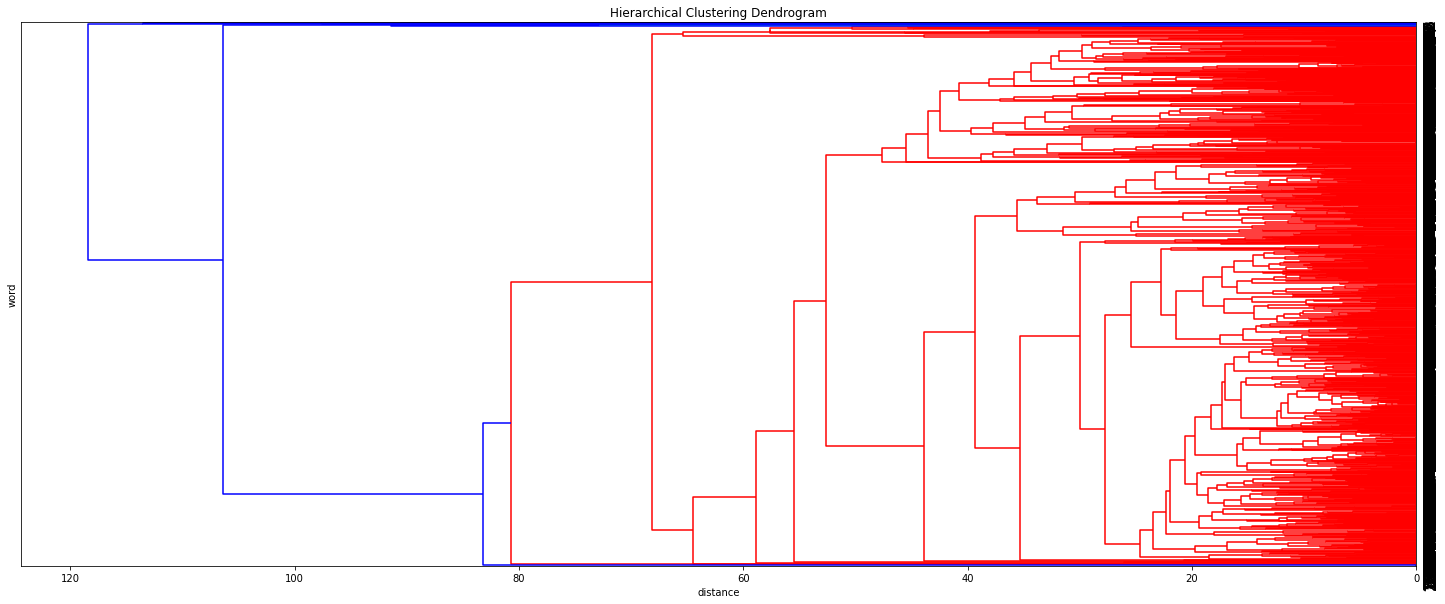

In [25]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

l = linkage(embeddings, method='complete', metric='seuclidean')
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

dendrogram(
    l,
    leaf_rotation=90.,  
    leaf_font_size=16.,  
    orientation='left',
)
plt.show()

### Вывод

Совершенно неинформативно

### Предложение 6

Попробуем воспользоваться kmeans и посмотреть на расстояния внутри одного кластера и как они меняются

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm

distances = []
for k in tqdm(range(1,100)):
    km = KMeans(n_clusters=k)
    km = km.fit(embeddings)
    distances.append(km.inertia_)

In [ ]:
plt.plot(range(1,100), distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
X = StandardScaler().fit_transform(embeddings)

dbscan = DBSCAN(eps=10, min_samples = 2)
clusters = dbscan.fit_predict(X)
# plot the cluster assignments
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

### Вывод
- Классов точно должно быть много (Больше 100)
- DBSCAN бессмысленно применять 

### Пример кластеризации 
Используем тупенький k-means просто посмотреть, что получится

In [ ]:
model = KMeans(n_clusters=150)
model = model.fit(embeddings)

In [ ]:
df_res = pd.DataFrame(zip(model.labels_, phrases))

In [ ]:
df_res[df_res[0] == 6]

### Вывод

Что-то полуилось, но слишком много того, что должно быть в одном классе - в разных и наоборот, Работаем дальше

### Предложение 7 
Пока все не очень хорошо. Оказывается, это из-за того, что у нас много ненужных частей речи.
Попробуем поработать с фразами, лемматизировать их выкинуть предлоги, союзы и тд

In [ ]:
df["company_categories_norm"] = df["company_categories_norm"].apply(lambda x: delete_prep(x))
df["company_categories_norm"] = df["company_categories_norm"].apply(lambda x: lemmatize(x))

### Предложение 8.
Визуализируем

In [ ]:
df['embedding'] = df.company_categories_norm.apply(lambda x: get_phrase_embedding(x))

embeddings = np.matrix(df['embedding'].tolist())
word_tsne = TSNE(n_components=2).fit_transform(embeddings) 
draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='green', token=phrases)

### Вывод
Уже неплохо! Надо придумать только какое-то явное определение кластера

### Предложение 9
Попробуем по описанию вектора признаков найти одно слово, которое описывает описание компании. Представим, что это и будет некоторое описание класса.

In [ ]:
df['most_similar'] = df['embedding'].apply(lambda x: MODEL.most_similar(np.array([x]))[0][0])

### Предложение 10
Посмотрим на количество описательных слов и их значения

In [ ]:
len(set(df.most_similar.values))

In [ ]:
set(df.most_similar.values)

In [ ]:
df[df['most_similar'] == 'туризм']

# Вывод:

Алгоритм поиска кластера
    - Выкидываем всю пунктуацию, предлоги, союзы и тд из предложений
    - Лемматизируем все предложения
    - С помощью модели word2vec находи одно описательное слово данного класса, лематизируем его - это и есть по сути класс
    
 
Для текущего датасета получилось разбить на 306 кластеров, каждый кластер обладает не только значеним от 0 до 306, но и описанием одним словом данного кластера.